<a href="https://colab.research.google.com/github/dhruthick/Network-Intrusion-Detection/blob/master/miniproject_intrusiondetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Network Intrusion detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

#for data pre processing and dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

# various classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score,\
    train_test_split, StratifiedKFold

#for  evaluation
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report,accuracy_score

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

##Loading the dataset
The UNSW website provdies separate datasets that are sampled from the larger dataset (2.5 million in size) for network intrusion detetction as training and test set. The size of the training and test sets are described below.

In [ ]:
path="/content/drive/My Drive/DDoS attack - Mini Project"

In [ ]:
path="/content/drive/My Drive/DDoS attack - Mini Project"
nX=pd.read_csv(path+"/nb15unpretrain.csv")
nX_test=pd.read_csv(path+"/nb15unpretest.csv")

print("Training set size:",nX.shape)
print("Test set size:",nX_test.shape)

Training set size: (175341, 45)
Test set size: (82332, 45)


In [ ]:
nX.head(200)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8.495365e+03,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,5.035713e+05,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,6.092923e+04,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3.358622e+03,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3.987060e+03,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,0.001061,udp,dns,CON,2,2,146,178,2827.521083,31,29,550424.125000,6.710650e+05,0,0,0.009000,0.007000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,73,89,0,0,8,0,1,2,1,4,0,0,0,4,12,0,Normal,0
196,197,0.001064,udp,dns,CON,2,2,132,164,2819.548997,31,29,496240.625000,6.165414e+05,0,0,0.009000,0.007000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,66,82,0,0,8,0,1,2,1,3,0,0,0,4,3,0,Normal,0
197,198,0.003081,tcp,ftp-data,FIN,6,8,320,1826,4219.409359,31,29,693281.437500,4.149302e+06,1,2,0.551000,0.363857,30.809398,0.614728,255,2022074493,4180968900,255,0.000665,0.000531,0.000134,53,228,0,0,3,0,10,1,1,4,0,0,0,13,3,0,Normal,0
198,199,0.001115,udp,dns,CON,2,2,146,178,2690.582979,31,29,523766.812500,6.385650e+05,0,0,0.009000,0.007000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,73,89,0,0,6,0,4,2,1,1,0,0,0,2,5,0,Normal,0


In [ ]:
#id column is  not required
nX.drop(["id"],axis=1,inplace=True)
nX_test.drop(["id"],axis=1,inplace=True)

The dataset consists of 42 features and 2 labelled columns (*attack_cat* and *label*).


> *label* states weather the data is of normal flow or that of an attack, with 0 for normal and 1 for attack.

> *attack_cat* describes the type of attack (among 9 varieties).






In [ ]:
nX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  object 
 2   service            175341 non-null  object 
 3   state              175341 non-null  object 
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [ ]:
mask = nX.label == 1
print("No. of attacks:", nX[mask].label.size)
print("No. of normal: ", nX[~mask].label.size)

No. of attacks: 119341
No. of normal:  56000


In [ ]:
#percentage of attacks in training data
np.sum(nX.label == 1)/nX.shape[0]

0.6806223302022916

##Data pre-processing
the dataset contains 3 nominal features that require encoding


> *proto* - denotes the transaction protocol being used

>*state* - The state and its dependent protocol, e.g.
ACC, CLO, else (-) 

>*service* - http, ftp, ssh, dns ..,else (-) 

In [ ]:
print(nX.proto.unique())
print("No. of unique values:",nX.proto.unique().size)

['tcp' 'udp' 'arp' 'ospf' 'icmp' 'igmp' 'rtp' 'ddp' 'ipv6-frag' 'cftp'
 'wsn' 'pvp' 'wb-expak' 'mtp' 'pri-enc' 'sat-mon' 'cphb' 'sun-nd' 'iso-ip'
 'xtp' 'il' 'unas' 'mfe-nsp' '3pc' 'ipv6-route' 'idrp' 'bna' 'swipe'
 'kryptolan' 'cpnx' 'rsvp' 'wb-mon' 'vmtp' 'ib' 'dgp' 'eigrp' 'ax.25'
 'gmtp' 'pnni' 'sep' 'pgm' 'idpr-cmtp' 'zero' 'rvd' 'mobile' 'narp' 'fc'
 'pipe' 'ipcomp' 'ipv6-no' 'sat-expak' 'ipv6-opts' 'snp' 'ipcv'
 'br-sat-mon' 'ttp' 'tcf' 'nsfnet-igp' 'sprite-rpc' 'aes-sp3-d' 'sccopmce'
 'sctp' 'qnx' 'scps' 'etherip' 'aris' 'pim' 'compaq-peer' 'vrrp' 'iatp'
 'stp' 'l2tp' 'srp' 'sm' 'isis' 'smp' 'fire' 'ptp' 'crtp' 'sps'
 'merit-inp' 'idpr' 'skip' 'any' 'larp' 'ipip' 'micp' 'encap' 'ifmp'
 'tp++' 'a/n' 'ipv6' 'i-nlsp' 'ipx-n-ip' 'sdrp' 'tlsp' 'gre' 'mhrp' 'ddx'
 'ippc' 'visa' 'secure-vmtp' 'uti' 'vines' 'crudp' 'iplt' 'ggp' 'ip'
 'ipnip' 'st2' 'argus' 'bbn-rcc' 'egp' 'emcon' 'igp' 'nvp' 'pup' 'xnet'
 'chaos' 'mux' 'dcn' 'hmp' 'prm' 'trunk-1' 'xns-idp' 'leaf-1' 'leaf-2'
 'rdp' 'irtp

The protocol field has 133 unique values. One-hot encoding all of them will add an additional 132 features to the dataset, so, we consider only the four most occurring values (*tcp, udp, unas* and*, arp*) and rename the rest of them as *other*

In [ ]:
nX.proto.value_counts().head(10)

tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
sctp       1150
any         300
gre         225
pim         201
sun-nd      201
Name: proto, dtype: int64

In a similar manner we take the 3 most and 2 most occurring values in the *state* and *service* columns and replace the rest with *other*

In [ ]:
nX.state.value_counts()

INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
URN        1
no         1
PAR        1
Name: state, dtype: int64

In [ ]:
nX.service.value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [ ]:
#function to replace values with "other"
def reduce_column(s, to_keep):
    s = s.lower().strip()
    if s not in to_keep:
        return 'other'
    else:
        return s

In [ ]:
transformations = {
    'proto':['tcp', 'udp', 'arp', 'unas'],
    'state':['fin', 'con', 'int'],
    'service':['-', 'dns']
}
for col, keepers in transformations.items():
    nX[col] = nX[col].apply(reduce_column, args=(keepers,))
    nX_test[col] = nX_test[col].apply(reduce_column, args=(keepers,))

The dataset has 3 nominal features and 2 binary features that do not need to be scaled. Below a pipeline is set up for one-hot encoding and standard scaling the dataset.

In [ ]:
droppable_cols =["attack_cat"]
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
target_cols = ['label']
ohe_step = ('ohe', OneHotEncoder(sparse=False))
ssc_step = ('std_sclr', StandardScaler())
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])
ohe_cols = ['proto', 'state', 'service']
non_ssc_cols = ohe_cols+binary_cols+target_cols+droppable_cols
ssc_cols = [col for col in nX.columns if col not in non_ssc_cols]
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]
ct = ColumnTransformer(transformers=transformer, remainder='passthrough')
cat_cols = np.concatenate((np.sort(nX.proto.unique()),
                           np.sort(nX.state.unique()),
                           np.sort(nX.service.unique())))
new_cols =  np.concatenate((cat_cols, ssc_cols, binary_cols, target_cols))

In [ ]:
#acquiring the training, cross validation, and test sets with labels
ny=nX[["attack_cat","label"]]
ny_test=nX_test[["attack_cat","label"]]
nX_train,nX_cval,ny_train,ny_cval=train_test_split(nX,ny["label"],test_size=0.2,stratify=ny["label"])

In [ ]:
#transforming the training, cross validation and test sets
nX_train = pd.DataFrame(ct.fit_transform(nX_train.drop(columns=droppable_cols)))
nX_train.columns=new_cols
nX_cval = pd.DataFrame(ct.transform(nX_cval.drop(columns=droppable_cols)))
nX_cval.columns=new_cols
nX_test = pd.DataFrame(ct.transform(nX_test.drop(columns=droppable_cols)))
nX_test.columns=new_cols

In [ ]:
nX_train.head()

,arp,other,tcp,udp,unas,con,fin,int,other,-,dns,other,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,is_ftp_login,label
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.210171,-0.136710,-0.168436,-0.049788,-0.102311,0.636072,0.723994,-0.721305,0.463228,-0.277522,-0.076240,-0.129141,-0.136432,-0.088576,-0.110735,-0.148614,-0.915884,-0.715701,-0.716151,-0.907064,-0.521254,-0.482636,-0.501909,-0.179774,-0.481181,-0.128552,-0.043954,0.252782,0.731149,-0.023626,-0.295705,-0.208234,0.756589,-0.120001,-0.188929,-0.114831,0.270835,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.210171,-0.136710,-0.168436,-0.050294,-0.102311,0.029464,0.723994,-0.721305,-0.147905,-0.277522,-0.076240,-0.129141,-0.136432,-0.088576,-0.110735,-0.148614,-0.915884,-0.715701,-0.716151,-0.907064,-0.521254,-0.482636,-0.501909,-0.389922,-0.481181,-0.128552,-0.043954,2.309697,0.731149,3.452812,3.556217,2.383218,2.309639,-0.120001,-0.188929,3.247672,2.317564,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.210728,-0.061789,-0.080569,-0.044429,-0.096755,-0.577097,0.723994,1.557908,-0.391488,-0.276624,-0.029484,-0.092517,-0.103309,0.205550,0.225772,-0.025013,1.091884,-0.558921,-0.172418,1.102479,1.922979,1.789115,1.842392,-0.213984,-0.160831,-0.128552,-0.043954,-0.588683,-0.318206,-0.644418,-0.419960,-0.553761,-0.705105,-0.120001,-0.188929,-0.595189,-0.752529,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.210171,-0.136710,-0.168436,-0.050353,-0.102311,0.029464,0.723994,-0.721305,-0.169273,-0.277522,-0.076240,-0.129141,-0.136432,-0.088576,-0.110735,-0.148614,-0.915884,-0.715701,-0.716151,-0.907064,-0.521254,-0.482636,-0.501909,-0.414358,-0.481181,-0.128552,-0.043954,-0.495187,0.731149,-0.520260,-0.544216,-0.553761,-0.522394,-0.120001,-0.188929,-0.715278,-0.566463,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.176086,-0.046804,-0.115716,0.001608,-0.100158,-0.576624,-1.441993,-0.459015,-0.389907,-0.273544,-0.013898,-0.110829,-0.134084,-0.044207,-0.076609,-0.132573,1.091884,0.022356,0.606382,1.102479,-0.514091,-0.472186,-0.499107,2.449531,-0.276620,-0.128552,-0.043954,-0.588683,-1.367560,-0.520260,-0.544216,-0.553761,-0.339682,-0.120001,-0.188929,-0.595189,-0.566463,0.0,0.0,0.0


In [ ]:
nX_train.drop(["label"],axis=1,inplace=True)
nX_cval.drop(["label"],axis=1,inplace=True)
nX_test.drop(["label"],axis=1,inplace=True)

##Data visualization
Principal component analysis and t-SNE are both used to reduce the dimension of the dataset for 2-D visualization

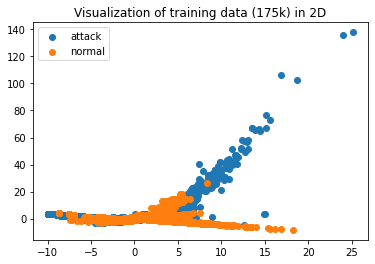

In [ ]:
#PCA
pca=PCA(n_components=2)
mask= ny_train==1
nX_trainPCA=pca.fit_transform(nX_train)
plt.scatter(nX_trainPCA[mask,0], nX_trainPCA[mask,1],label="attack")
plt.scatter(nX_trainPCA[~mask,0], nX_trainPCA[~mask,1],label="normal")
plt.title("Visualization of training data (175k) in 2D")
plt.legend()
#plot using PCA

In [ ]:
#DO NOT RUN - takes 30 minutes
tsne=TSNE()
nX_trainTSNE=tsne.fit_transform(nX_train)


NameError: ignored

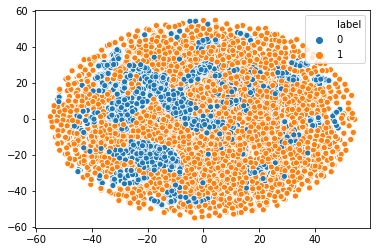

In [ ]:
#plot using t-SNE
sns.scatterplot(nX_trainTSNE[:,0],nX_trainTSNE[:,1],hue=ny_train, legend="full")
#1- attack, 0- normal

##Training and Testing
We train and test six different classifiers for binary classification

In [ ]:
classifiers = {
    'K-nearest Neighnbors': KNeighborsClassifier() ,
    'Logistic Regression': LogisticRegression(random_state=42) ,
    'Gaussian Naive Bayes': GaussianNB() ,
    'Decision Tree': DecisionTreeClassifier(random_state=42) ,
    'Random Forest': RandomForestClassifier(random_state=42) ,
    'Gradient Boost': GradientBoostingClassifier(random_state=42) 
}
for clf_name,clf in classifiers.items():
  print(clf_name)
  clf.fit(nX_train,ny_train)
  print("AUC scores")
  print('Train: ', roc_auc_score(ny_train, clf.predict(nX_train)))
  print('Cross validation: ', roc_auc_score(ny_cval, clf.predict(nX_cval)))
  ny_pred=clf.predict(nX_test)
  print('Test:', roc_auc_score(ny_test["label"],ny_pred))
  print("Confusion_matrix:")
  print(confusion_matrix(ny_test["label"], ny_pred))
  print(classification_report(ny_test["label"],ny_pred))

K-nearest Neighnbors
AUC scores
Train:  0.9468288495953937
Cross validation:  0.9228249732169042
Test: 0.8308594954700574
Confusion_matrix:
[[25743 11257]
 [ 1543 43789]]
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     37000
           1       0.80      0.97      0.87     45332

    accuracy                           0.84     82332
   macro avg       0.87      0.83      0.84     82332
weighted avg       0.86      0.84      0.84     82332

Logistic Regression


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUC scores
Train:  0.9054291497581939
Cross validation:  0.9084629439410352
Test: 0.7966975980215635
Confusion_matrix:
[[22549 14451]
 [  727 44605]]
              precision    recall  f1-score   support

           0       0.97      0.61      0.75     37000
           1       0.76      0.98      0.85     45332

    accuracy                           0.82     82332
   macro avg       0.86      0.80      0.80     82332
weighted avg       0.85      0.82      0.81     82332

Gaussian Naive Bayes
AUC scores
Train:  0.8281551509492686
Cross validation:  0.8255159075130324
Test: 0.781621018265243
Confusion_matrix:
[[30858  6142]
 [12274 33058]]
              precision    recall  f1-score   support

           0       0.72      0.83      0.77     37000
           1       0.84      0.73      0.78     45332

    accuracy                           0.78     82332
   macro avg       0.78      0.78      0.78     82332
weighted avg       0.79      0.78      0.78     82332

Decision Tree
AUC scores
T

We observed that all the classifiers gave a better AUC (Area under ROC curve) scores on the cross-validation set than on the test set. The cross-validation set was split from train data provided unlike the test set which was provided separately, it led us to believe that the training set did not contain enough records to represent the test set.

So, we loaded the entire raw dataset (2.5 million records) before it was sampled for training and test data.

##Loading the Full UNSW-NB15 dataset

In [ ]:
dfs = []
for i in range(1,5):
    rpath = path+'/UNSW-NB15_{}.csv'
    dfs.append(pd.read_csv(rpath.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data_info = pd.read_csv(path+"/NUSW-NB15_features.csv", encoding = "ISO-8859-1", header=None).values
features = data_info[1:-2,:]
feature_names = features[:, 1] 

In [ ]:
feature_names=list(feature_names)
feature_names.append("attack_cat")
feature_names.append("label")
for i in range(0,len(feature_names)):
  feature_names[i]=feature_names[i].lower()
all_data.columns=feature_names

In [ ]:
all_data.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0


In [ ]:
all_data.shape

(2540047, 49)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

Unlike the training and test set provided by UNSW, the full dataset has 6 extra features (destination and source port and IP address along with their timestamps) that we will drop.

##Data pre processing steps on the full dataset

In [ ]:
#filling blanks and NaNs in the dataset
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())
all_data['ct_ftp_cmd'] = all_data.ct_ftp_cmd.replace(to_replace=' ', value=0).astype(int)
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0) >0).astype(int)

In [ ]:
all_data.isnull().sum().sum()

0

In [ ]:
#reducing the column values of nominal features like before
transformations = {
    'proto':['tcp', 'udp', 'arp', 'unas'],
    'state':['fin', 'con', 'int'],
    'service':['-', 'dns']
}
for col, keepers in transformations.items():
    all_data[col] = all_data[col].apply(reduce_column, args=(keepers,))

In [ ]:
mask = all_data.label == 1
print("No. of attacks:", all_data[mask].label.size)
print("No. of normal: ", all_data[~mask].label.size)

No. of attacks: 321283
No. of normal:  2218764


In [ ]:
#percentage of attacks
np.sum(all_data.label == 1)/all_data.shape[0]

0.12648702957071267

In [ ]:
#One hot encoding and standard scaling after dropping the extra 6 features
droppable_cols = ['srcip', 'sport', 'dstip', 'dsport', 'ltime', 'stime', 'attack_cat']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
target_cols = ['label']
ohe_step = ('ohe', OneHotEncoder(sparse=False))
ssc_step = ('std_sclr', StandardScaler())
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])
ohe_cols = ['proto', 'state', 'service']
non_ssc_cols = ohe_cols+droppable_cols+binary_cols+target_cols
ssc_cols = [col for col in all_data.columns if col not in non_ssc_cols]
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]

In [ ]:
ct = ColumnTransformer(transformers=transformer, remainder='passthrough')
cat_cols = np.concatenate((np.sort(all_data.proto.unique()),
                           np.sort(all_data.state.unique()),
                           np.sort(all_data.service.unique())))
new_cols =  np.concatenate((cat_cols, ssc_cols, binary_cols, target_cols))
new_data = pd.DataFrame(ct.fit_transform(all_data.drop(columns=droppable_cols)))
new_data.columns = new_cols

In [ ]:
new_data.head()

,3pc,a/n,aes-sp3-d,any,argus,aris,arp,ax.25,bbn-rcc,bna,br-sat-mon,cbt,cftp,chaos,compaq-peer,cphb,cpnx,crtp,crudp,dcn,ddp,ddx,dgp,egp,eigrp,emcon,encap,esp,etherip,fc,fire,ggp,gmtp,gre,hmp,i-nlsp,iatp,ib,icmp,idpr,...,ssl,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,synack,ackdat,ct_state_ttl,ct_flw_http_mthd,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_sm_ips_ports,is_ftp_login,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.047234,-0.074595,-0.225105,-0.425902,-0.041232,-0.229334,-0.288533,-0.307375,-0.432928,-0.410163,-0.335193,-1.196094,-1.192778,-0.887256,-0.887232,-0.383459,-0.580043,-0.237863,-0.089307,-0.093968,-0.212320,-0.069555,-0.054990,-0.133896,-0.126759,-0.120805,-0.38231,-0.197833,-0.111508,-0.572772,-0.183780,-0.666391,-0.475437,-0.429620,-0.419913,-0.519252,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.044715,-0.067574,-0.224236,-0.425902,-0.041232,-0.229334,-0.288533,-0.310855,-0.568156,-0.383945,-0.318733,-1.196094,-1.192778,-0.887256,-0.887232,0.050991,-0.597920,-0.237863,-0.089307,-0.093383,-0.209214,-0.067041,-0.049722,-0.133896,-0.126759,-0.120805,-0.38231,-0.197833,-0.111508,-0.665051,-0.460981,-0.543872,-0.475437,-0.429620,-0.419913,-0.430429,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.047230,-0.074347,-0.225019,-0.425902,-0.041232,-0.229334,-0.288533,-0.307194,-0.429500,-0.410163,-0.335193,-1.196094,-1.192778,-0.887256,-0.887232,-0.337381,-0.559185,-0.237863,-0.089307,-0.093968,-0.212320,-0.069555,-0.054990,-0.133896,-0.126759,-0.120805,-0.38231,-0.197833,-0.111508,0.257735,-0.091380,-0.666391,-0.597313,-0.311662,-0.419913,-0.519252,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.047223,-0.074595,-0.225105,-0.425902,-0.041232,-0.229334,-0.288533,-0.307912,-0.451675,-0.410163,-0.335193,-1.196094,-1.192778,-0.887256,-0.887232,-0.383459,-0.580043,-0.237863,-0.089307,-0.093968,-0.212320,-0.069546,-0.054990,-0.133896,-0.126759,-0.120805,-0.38231,-0.197833,-0.111508,-0.295936,0.001020,-0.666391,-0.719189,-0.429620,-0.419913,-0.519252,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.047226,-0.074347,-0.225019,-0.425902,-0.041232,-0.229334,-0.288533,-0.307382,-0.435942,-0.410163,-0.335193,-1.196094,-1.192778,-0.887256,-0.887232,-0.337381,-0.559185,-0.237863,-0.089307,-0.093968,-0.212320,-0.069560,-0.054997,-0.133896,-0.126759,-0.120805,-0.38231,-0.197833,-0.111508,-0.203658,0.001020,-0.666391,-0.719189,-0.429620,-0.419913,-0.519252,0.0,0.0,0.0


In [ ]:
datay=all_data[["label","attack_cat"]]
dataX=all_data.drop(["label","attack_cat"],axis=1,inplace=False)

Sampling 35% of the dataset (maintaining the same proportions of attacks and normal data) as it is too large.

In [ ]:
Xrest, X, yrest, y = train_test_split(dataX, datay,
                                            test_size=0.35, stratify=datay["label"])

In [ ]:
#percentage of attacks
np.sum(y["label"] == 1)/y.shape[0]

0.12648689507624714

In [ ]:
#splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y["label"],
                                            test_size=0.25, stratify=y["label"])

In [ ]:
print("Training set size:",X_train.shape)
print("Test set size:",X_test.shape)

Training set size: (666762, 47)
Test set size: (222255, 47)


In [ ]:
#applying the transformations
d_cols=droppable_cols.copy()
d_cols.remove("attack_cat")
X_train=pd.DataFrame(ct.fit_transform(X_train.drop(columns=d_cols)))
X_test=pd.DataFrame(ct.transform(X_test.drop(columns=d_cols)))
n_cols=new_cols.tolist()
n_cols.remove("label")
X_train.columns=n_cols
X_test.columns=n_cols

ValueError: ignored

In [ ]:
X_train

##Visualization of full dataset

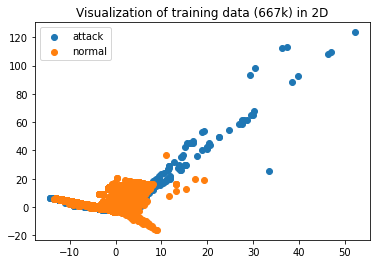

In [ ]:
pca=PCA(n_components=2)
mask= y_train==1
X_trainPCA=pca.fit_transform(X_train)
plt.scatter(X_trainPCA[mask,0], X_trainPCA[mask,1],label="attack")
plt.scatter(X_trainPCA[~mask,0], X_trainPCA[~mask,1],label="normal")
plt.title("Visualization of training data (667k) in 2D")
plt.legend()

##Training and testing classifiers

In [ ]:
classifiers = {
    'knn': KNeighborsClassifier() ,
    'lgr': LogisticRegression(random_state=42) ,
    'gnb': GaussianNB() ,
    'dtc': DecisionTreeClassifier(random_state=42) ,
    'rfc': RandomForestClassifier(random_state=42) ,
    'gbc': GradientBoostingClassifier(random_state=42) 
}

In [ ]:
for clf_name,clf in classifiers.items():
  print(clf_name)
  clf.fit(X_train,y_train)
  print("Training Accuracy:",clf.score(X_train,y_train))
  y_pred=clf.predict(X_test)
  print("Test Accuracy:",accuracy_score(y_test,y_pred))
  print('Test AUC score:', roc_auc_score(y_test,y_pred))
  print("Confusion_matrix:")
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test,y_pred))

knn
Training Accuracy: 0.9932239689724369
Test Accuracy: 0.9898674945445547
Test AUC score: 0.9773011996638872
Confusion_matrix:
[[193002   1141]
 [  1111  27001]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    194143
           1       0.96      0.96      0.96     28112

    accuracy                           0.99    222255
   macro avg       0.98      0.98      0.98    222255
weighted avg       0.99      0.99      0.99    222255

lgr


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy: 0.9890065720601954
Test Accuracy: 0.9891925940923714
Test AUC score: 0.9834402242948844
Confusion_matrix:
[[192423   1720]
 [   682  27430]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    194143
           1       0.94      0.98      0.96     28112

    accuracy                           0.99    222255
   macro avg       0.97      0.98      0.98    222255
weighted avg       0.99      0.99      0.99    222255

gnb
Training Accuracy: 0.8945005864161425
Test Accuracy: 0.8932262491282535
Test AUC score: 0.9294064893852731
Confusion_matrix:
[[171035  23108]
 [   623  27489]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    194143
           1       0.54      0.98      0.70     28112

    accuracy                           0.89    222255
   macro avg       0.77      0.93      0.82    222255
weighted avg       0.94      0.89      0.91    222255

dtc
Training Accuracy:

Observing the precision and recall scores of the above classifiers, random forest classifier gives the best performance

In [ ]:
#testing on another random sample from the full dataset.
Xrest, X_randtest, yrest, y_randtest = train_test_split(dataX, datay,
                                            test_size=0.2)
print(X_randtest.shape)

(508010, 47)


In [ ]:
X_randtest=pd.DataFrame(ct.transform(X_randtest.drop(columns=d_cols)))
X_randtest.columns=n_cols

In [ ]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
print("Training Accuracy:",rfc.score(X_train,y_train))
y_pred=rfc.predict(X_randtest)
print("Test Accuracy:",accuracy_score(y_randtest['label'],y_pred))
print('Test AUC score:', roc_auc_score(y_randtest['label'],y_pred))
print("Confusion_matrix:")
print(confusion_matrix(y_randtest['label'], y_pred))
print(classification_report(y_randtest['label'],y_pred))

Training Accuracy: 0.9998485216614024
Test Accuracy: 0.9950768685655794
Test AUC score: 0.9885764479076019
Confusion_matrix:
[[442384   1204]
 [  1297  63125]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443588
           1       0.98      0.98      0.98     64422

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [ ]:
path

'/content/drive/My Drive/DDoS attack - Mini Project'

In [ ]:
import pickle
from sklearn.externals import joblib
filename=path+'/rfcbinary.pkl'
joblib.dump(rfc,filename)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


NameError: ignored

In [ ]:
rfcloaded=joblib.load(filename)
y_pred=rfcloaded.predict(X_randtest)
print("Test Accuracy:",accuracy_score(y_randtest['label'],y_pred))
print('Test AUC score:', roc_auc_score(y_randtest['label'],y_pred))
print("Confusion_matrix:")
print(confusion_matrix(y_randtest['label'], y_pred))
print(classification_report(y_randtest['label'],y_pred))

Test Accuracy: 0.9929922639318124
Test AUC score: 0.9891443125273092
Confusion_matrix:
[[441307   2533]
 [  1027  63143]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    443840
           1       0.96      0.98      0.97     64170

    accuracy                           0.99    508010
   macro avg       0.98      0.99      0.98    508010
weighted avg       0.99      0.99      0.99    508010



##Multi-Class Classification
After detection of an attack, classifying the type of attack is the next step

In [ ]:
all_attackdata=all_data[all_data["label"]==1]
all_attackdata.shape

(321283, 49)

In [ ]:
all_attackdata.attack_cat.value_counts()

generic           215481
exploits           44525
fuzzers            24246
dos                16353
reconnaissance     13987
analysis            2677
backdoor            1795
shellcode           1511
backdoors            534
worms                174
Name: attack_cat, dtype: int64

In [ ]:
#data preprocessing
all_attackdata['attack_cat'] = all_attackdata.attack_cat.replace(to_replace='backdoors', value="backdoor").astype(object)
all_attackdata.attack_cat.value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


generic           215481
exploits           44525
fuzzers            24246
dos                16353
reconnaissance     13987
analysis            2677
backdoor            2329
shellcode           1511
worms                174
Name: attack_cat, dtype: int64

There are 9 different types of attacks in the dataset as shown above along with their counts.

In [ ]:
#splitting into training and test set
all_attackdata.drop(["label"],axis=1,inplace=True)
attackdataX=all_attackdata.drop(['attack_cat'],axis=1,inplace=False)
attackdatay=all_attackdata["attack_cat"]
attackX_train,attackX_test,attacky_train,attacky_test=train_test_split(attackdataX,attackdatay,test_size=0.2,stratify=attackdatay)
print("Training size:",attackX_train.shape)
print("Test set size:",attackX_test.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Training size: (257026, 47)
Test set size: (64257, 47)


In [ ]:
#one hot encoding and scaling like before
droppable_cols = ['srcip', 'sport', 'dstip', 'dsport', 'ltime', 'stime']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
ohe_step = ('ohe', OneHotEncoder(sparse=False))
ssc_step = ('std_sclr', StandardScaler())
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])
ohe_cols = ['proto', 'state', 'service']
non_ssc_cols = ohe_cols+droppable_cols+binary_cols
ssc_cols = [col for col in attackX_train.columns if col not in non_ssc_cols]
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]
ct = ColumnTransformer(transformers=transformer, remainder='passthrough')
cat_cols = np.concatenate((np.sort(attackX_train.proto.unique()),
                           np.sort(attackX_train.state.unique()),
                           np.sort(attackX_train.service.unique())))
new_cols =  np.concatenate((cat_cols, ssc_cols, binary_cols))

In [ ]:
#applying the transformations
attackX_train=pd.DataFrame(ct.fit_transform(attackX_train.drop(columns=droppable_cols)))
attackX_test=pd.DataFrame(ct.transform(attackX_test.drop(columns=droppable_cols)))
attackX_train.columns=new_cols
attackX_test.columns=new_cols

In [ ]:
#DO NOT RUN - takes 70 minutes
#Dimensionality reduction using t-SNE
tsne=TSNE()
attackX_trainTSNE=tsne.fit_transform(attackX_train)

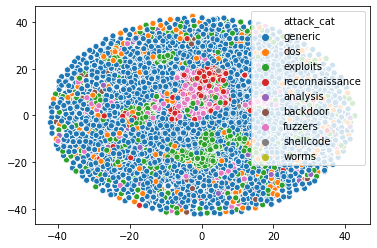

In [ ]:
#visualization using t-SNE
sns.scatterplot(attackX_trainTSNE[:,0],attackX_trainTSNE[:,1],hue=attacky_train,legend="full")

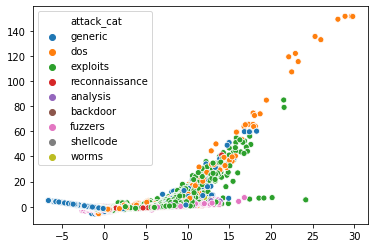

In [ ]:
#visualization using PCA
pca=PCA(n_components=2)
attackX_trainPCA=pca.fit_transform(attackX_train)
sns.scatterplot(attackX_trainPCA[:,0],attackX_trainPCA[:,1],hue=attacky_train,legend="full")

In [ ]:
#Random Forest Classifier
#has given the best performance so far
rfc=RandomForestClassifier(random_state=42)
rfc.fit(attackX_train,attacky_train)
print(rfc.score(attackX_test,attacky_test))
attacky_pred=rfc.predict(attackX_test)
print(confusion_matrix(attacky_test,attacky_pred))
print(classification_report(attacky_test,attacky_pred))

0.8919650777347216
[[   93     1   106   282    50     3     0     0     0]
 [    0    34   116   249    60     2     3     2     0]
 [    2     1   810  2288    94    28    17    30     1]
 [    9     9  1075  7336   262    59   135    20     0]
 [    4     7   107   432  4258     8     8    25     0]
 [    4     2   117   467    59 42432     3    12     1]
 [    1     2   144   478    10     2  2156     3     1]
 [    0     0     3    37    60     5     5   192     0]
 [    0     0     0    28     2     1     0     0     4]]
                precision    recall  f1-score   support

      analysis       0.82      0.17      0.29       535
      backdoor       0.61      0.07      0.13       466
           dos       0.33      0.25      0.28      3271
      exploits       0.63      0.82      0.72      8905
       fuzzers       0.88      0.88      0.88      4849
       generic       1.00      0.98      0.99     43097
reconnaissance       0.93      0.77      0.84      2797
     shellcode    

In [ ]:
#Decision tree
dtc=DecisionTreeClassifier(random_state=42)
dtc.fit(attackX_train,attacky_train)
print(dtc.score(attackX_test,attacky_test))
attacky_pred=dtc.predict(attackX_test)
print(confusion_matrix(attacky_test,attacky_pred))
print(classification_report(attacky_test,attacky_pred))

0.886502637844904
[[   87     1   108   280    48    11     0     0     0]
 [    2    47   106   271    36     2     1     1     0]
 [    5     5   996  2109    77    39    23    16     1]
 [   39    18  1398  6841   274   111   185    27    12]
 [   20     2   164   488  4106    28     5    36     0]
 [    8     5   139   351    22 42550     5    16     1]
 [    0     4   156   485     8     6  2125    12     1]
 [    0     5    19    44    37     6     5   186     0]
 [    0     0     1     7     0     0     1     0    26]]
                precision    recall  f1-score   support

      analysis       0.54      0.16      0.25       535
      backdoor       0.54      0.10      0.17       466
           dos       0.32      0.30      0.31      3271
      exploits       0.63      0.77      0.69      8905
       fuzzers       0.89      0.85      0.87      4849
       generic       1.00      0.99      0.99     43097
reconnaissance       0.90      0.76      0.83      2797
     shellcode     

In [ ]:
#Guassian Naive Bayes
gnb=GaussianNB()
gnb.fit(attackX_train,attacky_train)
print(gnb.score(attackX_test,attacky_test))
attacky_pred=gnb.predict(attackX_test)
print(confusion_matrix(attacky_test,attacky_pred))
print(classification_report(attacky_test,attacky_pred))

0.69246930295532
[[   72   387     0     0     2     0     0     0    74]
 [   22   372     0     1     1     0     0    42    28]
 [  170  2350    37    46    23    17     8   140   480]
 [  262  3078    58   998    45    25     3   521  3915]
 [  569   696     1    95   638    50   178  1913   709]
 [   37   314     8    40    14 41999     6   191   488]
 [   34   423     4     1     8     5    49  1833   440]
 [    0     0     0     0     0     0     0   302     0]
 [    0     0     0     0     0     0     0     6    29]]
                precision    recall  f1-score   support

      analysis       0.06      0.13      0.08       535
      backdoor       0.05      0.80      0.09       466
           dos       0.34      0.01      0.02      3271
      exploits       0.85      0.11      0.20      8905
       fuzzers       0.87      0.13      0.23      4849
       generic       1.00      0.97      0.99     43097
reconnaissance       0.20      0.02      0.03      2797
     shellcode      

In [ ]:
#K-nearest Neighbor
knn=KNeighborsClassifier()
knn.fit(attackX_train,attacky_train)
print(knn.score(attackX_test,attacky_test))
attacky_pred=knn.predict(attackX_test)
print(confusion_matrix(attacky_test,attacky_pred))
print(classification_report(attacky_test,attacky_pred))

0.8573851876060196
[[   65    23   191   223    27     5     1     0     0]
 [   29     6   163   198    42     2    25     1     0]
 [  107    40  1245  1639   127    36    64    13     0]
 [  162    69  1720  6105   488    96   247    15     3]
 [   51    34   226   521  3751    29   221    16     0]
 [   15     7   218   484   112 42205    47     9     0]
 [   10    11   239   536   365     5  1625     5     1]
 [    0     1     9    34    81     6    84    87     0]
 [    0     0     0    21     6     2     2     0     4]]
                precision    recall  f1-score   support

      analysis       0.15      0.12      0.13       535
      backdoor       0.03      0.01      0.02       466
           dos       0.31      0.38      0.34      3271
      exploits       0.63      0.69      0.65      8905
       fuzzers       0.75      0.77      0.76      4849
       generic       1.00      0.98      0.99     43097
reconnaissance       0.70      0.58      0.64      2797
     shellcode    

We observe that though random forest perfoms the best among the above, the precision and recall values of dos, worms and exploits are low.
Furthermore, the precision of detecting a dos attack is low for all of the above classifiers, while for generic attacks it is 1.0. 

In [ ]:
mask = attacky_train == "generic"
print("No. of generic attacks:", attacky_train[mask].size)
print("No. of other attacks: ", attacky_train[~mask].size)

No. of generic attacks: 172384
No. of other attacks:  84642


The number of generic attacks in the dataset are more than the all the other attacks combined.

In [ ]:
attackdata_nogeneric=all_attackdata[all_attackdata["attack_cat"]!='generic']
attackdata_nogeneric.shape

(105802, 49)

In [ ]:
attackdata_nogeneric.drop(["label"],axis=1,inplace=True)
attackdata_nogenericX=attackdata_nogeneric.drop(['attack_cat'],axis=1,inplace=False)
attackdata_nogenericy=attackdata_nogeneric["attack_cat"]
attackNoGX_train,attackNoGX_test,attackNoGy_train,attackNoGy_test=train_test_split(attackdata_nogenericX,attackdata_nogenericy,test_size=0.2,stratify=attackdata_nogenericy)
print("Training size:",attackNoGX_train.shape)
print("Test set size:",attackNoGX_test.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Training size: (84641, 47)
Test set size: (21161, 47)


In [ ]:
#applying the transformations
attackNoGX_train=pd.DataFrame(ct.fit_transform(attackNoGX_train.drop(columns=droppable_cols)))
attackNoGX_test=pd.DataFrame(ct.transform(attackNoGX_test.drop(columns=droppable_cols)))
attackNoGX_train.columns=new_cols
attackNoGX_test.columns=new_cols

In [ ]:
tsne=TSNE()
attackX_trainTSNE=tsne.fit_transform(attackNoGX_train)

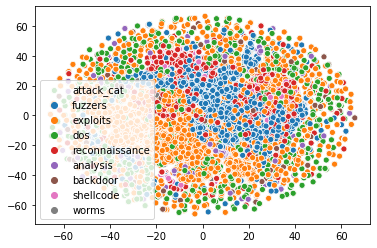

In [ ]:
#visualization using t-SNE
sns.scatterplot(attackX_trainTSNE[:,0],attackX_trainTSNE[:,1],hue=attackNoGy_train,legend="full")

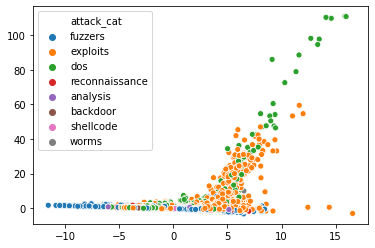

In [ ]:
pca=PCA(n_components=2)
attackNoGX_trainPCA=pca.fit_transform(attackNoGX_train)
sns.scatterplot(attackNoGX_trainPCA[:,0],attackNoGX_trainPCA[:,1],hue=attackNoGy_train,legend="full")

In [ ]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(attackNoGX_train,attackNoGy_train)
print(rfc.score(attackNoGX_train,attackNoGy_train))
print(rfc.score(attackNoGX_test,attackNoGy_test))
attackNoGy_pred=rfc.predict(attackNoGX_test)
print(confusion_matrix(attackNoGy_test,attackNoGy_pred))
print(classification_report(attackNoGy_test,attackNoGy_pred))

0.8042319915880011
0.7092292424743633
[[  90    1  101  297   46    0    0    0]
 [   1   47  108  250   54    3    3    0]
 [   2    1  829 2318   84   10   25    2]
 [  16    8 1009 7476  250  115   27    4]
 [  10    4  108  476 4229    1   21    0]
 [   0    2  132  520   15 2128    1    0]
 [   0    0    5   45   49    1  202    0]
 [   0    0    0   26    2    0    0    7]]
                precision    recall  f1-score   support

      analysis       0.76      0.17      0.28       535
      backdoor       0.75      0.10      0.18       466
           dos       0.36      0.25      0.30      3271
      exploits       0.66      0.84      0.74      8905
       fuzzers       0.89      0.87      0.88      4849
reconnaissance       0.94      0.76      0.84      2798
     shellcode       0.72      0.67      0.70       302
         worms       0.54      0.20      0.29        35

      accuracy                           0.71     21161
     macro avg       0.70      0.48      0.52     21161

In [ ]:
svm=SVC(gamma='auto')
svm.fit(attackNoGX_train,attackNoGy_train)
print(svm.score(attackNoGX_train,attackNoGy_train))
print(svm.score(attackNoGX_test,attackNoGy_test))
attackNoGy_pred=svm.predict(attackNoGX_test)
print(confusion_matrix(attackNoGy_test,attackNoGy_pred))
print(classification_report(attackNoGy_test,attackNoGy_pred))

0.6698763010833994
0.6635319691886017
[[  43    0    0  491    1    0    0    0]
 [   0    0    0  421   13   32    0    0]
 [   1    0   34 3084   80   64    8    0]
 [  12    0    4 8297  392  186   14    0]
 [   8    0   11  711 3884  231    4    0]
 [   1    0    7  828  215 1747    0    0]
 [   0    0    0   12   51  206   33    0]
 [   0    0    0   27    5    0    0    3]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

      analysis       0.66      0.08      0.14       535
      backdoor       0.00      0.00      0.00       466
           dos       0.61      0.01      0.02      3271
      exploits       0.60      0.93      0.73      8905
       fuzzers       0.84      0.80      0.82      4849
reconnaissance       0.71      0.62      0.66      2798
     shellcode       0.56      0.11      0.18       302
         worms       1.00      0.09      0.16        35

      accuracy                           0.66     21161
     macro avg       0.62      0.33      0.34     21161
  weighted avg       0.66      0.66      0.59     21161

